In [32]:
# 结合focal loss 函数讲解

In [33]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np

print(tf.__version__)
print(np.__version__)

2.0.0-rc0
1.18.4


## 数据集简介

In [34]:
mnist = np.load("mnist.npz")
x_train, y_train, x_test, y_test = mnist['x_train'], mnist['y_train'], mnist['x_test'], mnist['y_test']

In [35]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [36]:
x_test.shape

(10000, 28, 28)

In [37]:
x_train, x_test = x_train / 255.0, x_test /255.0

In [38]:
x_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

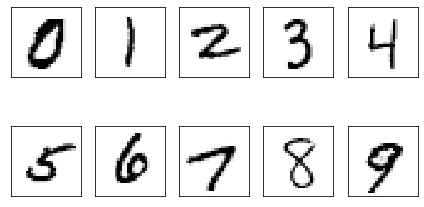

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True,)

ax = ax.flatten()
for i in range(10):
    img = x_train[y_train == i][10].reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [40]:
# add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


In [41]:
class MyModel(Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')
    
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

In [42]:
# 函数实现

In [43]:
def FocalLoss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.nn.softmax(y_pred,axis=-1)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0)
        
        y_true = tf.cast(y_true, tf.float32)
        
        loss = - y_true * tf.math.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        
        loss = tf.math.reduce_sum(loss,axis=1)
        return loss
    return focal_loss_fixed

In [44]:
model = MyModel()

# loss_object = tf.keras.losses.CategoricalCrossentropy()
loss_object = FocalLoss(gamma=2.0,alpha=0.25)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, prdictions)
    
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [45]:
EPOCHS = 20
for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_ds:
        test_step(images, labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    template = 'Epoch {}, Loss: {}, Accuracy: {} , Test Loss: {} , Test Accuracy: {}'
    print(template.format(epoch + 1,
                         train_loss.result(),
                         train_accuracy.result() * 100,
                         test_loss.result(),
                         test_accuracy.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.0, Accuracy: 0.0 , Test Loss: 1.8655757904052734 , Test Accuracy: 8.548571586608887
Epoch 2, Loss: 0.0, Accuracy: 0.0 , Test Loss: 1.8655765056610107 , Test Accuracy: 8.548571586608887
Epoch 3, Loss: 0.0, Accuracy: 0.0 , Test Loss: 1.8655729293823242 , Test Accuracy: 8.548571586608887
Epoch 4, Loss: 0.0, Accuracy: 0.0 , Test Loss: 1.8655749559402466 , Test Accuracy: 8.548571586608887
Epoch 5, Loss: 0.0, Accuracy: 0.0 , Test Loss: 1.8655749559402466 , Test Accuracy: 8.548571586608887
Epo